Dataset: Rare Event Classification in Multivariate Time Series https://arxiv.org/abs/1809.10717 (please cite this article, if using the dataset).

we used a Dense layer Autoencoder before that does not use the temporal features in the data. In this post, we will improve on our approach by building an LSTM Autoencoder.

Here, we will learn:
* data preparation steps for an LSTM model,
* building and implementing LSTM autoencoder, and
* using LSTM autoencoder for rare-event classification.

#### Quick recap on LSTM:
* LSTM is a type of Recurrent Neural Network (RNN). RNNs, in general, and LSTM, specifically, are used on sequential or time series data.
* These models are capable of automatically extracting effect of past events.
* LSTM are known for its ability to extract both long- and short- term effects of pasts event.

### LSTM Autoencoder for Multivariate Data

In our problem, we have a multivariate time-series data. A multivariate time-series data contains multiple variables observed over a period of time. We will build an LSTM autoencoder on this multivariate time-series to perform rare-event classification.

* we build an autoencoder on the normal (negatively labeled) data,
* use it to reconstruct a new sample,
* if the reconstruction error is high, we label it as a sheet-break.

LSTM requires few special data-preprocessing steps. In the following, we will give sufficient attention to these steps.
Let’s get to the implementation.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
import keras
import keras.utils
from tensorflow.keras import optimizers
from keras import Sequential#, optimizers
from keras.optimizers import adam_v2
from keras.models import Model
#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)
import tensorflow
tensorflow.random.set_seed(11)

from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

### Data preprocessing


The data is taken from https://arxiv.org/abs/1809.10717.

The input to LSTMs are 3-dimensional arrays created from the time-series data. This is an error prone step so we will look at the details.

In [2]:
df = pd.read_csv("processminer-rare-event-mts - data.csv")

In [3]:
df.head()

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


The objective of this rare-event problem is to predict a sheet-break before it occurs. We will try to predict the break 4 minutes in advance. 

To build this model, we will shift the labels 2 rows up (which corresponds to 4 minutes). We can do this as df.y=df.y.shift(-2). However, in this problem we would want to do the shifting as: if row n is positively labeled,
Make row (n-2) and (n-1) equal to 1. This will help the classifier learn up to 4 minute ahead prediction.

Delete row n. Because we do not want the classifier to learn predicting a break when it has happened.
We will develop the following UDF for this curve shifting.

In [4]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [5]:
'''
Shift the data by 2 units, equal to 4 minutes.

Test: Testing whether the shift happened correctly.
'''
print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['y'] == 1]
display(df.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(n=5))

# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = curve_shift(df, shift_by = -2)

print('After shifting')  # Validating if the shift happened correctly.
display(df.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(n=5))  

Before shifting


,time,y,x1,x2,x3
256,5/1/99 8:32,0,1.016235,-4.058394,-1.097158
257,5/1/99 8:34,0,1.005602,-3.876199,-1.074373
258,5/1/99 8:36,0,0.933933,-3.868467,-1.249954
259,5/1/99 8:38,1,0.892311,-13.332664,-10.006578
260,5/1/99 10:50,0,0.020062,-3.987897,-1.248529


After shifting


,y,time,x1,x2,x3
255,0.0,5/1/99 8:30,0.997107,-3.865720,-1.133779
256,0.0,5/1/99 8:32,1.016235,-4.058394,-1.097158
257,1.0,5/1/99 8:34,1.005602,-3.876199,-1.074373
258,1.0,5/1/99 8:36,0.933933,-3.868467,-1.249954
260,0.0,5/1/99 10:50,0.020062,-3.987897,-1.248529


If we note here, we moved the positive label at 5/1/99 8:38 to n-1 and n-2 timestamps, and dropped row n. Also, there is a time difference of more than 2 minutes between a break row and the next row. This is because, when a break occurs, the machine stays in the break status for a while. During this time, we have y = 1 for consecutive rows. In the provided data, these consecutive break rows are deleted to prevent the classifier from learning to predict a break after it has already happened.  Refer https://arxiv.org/abs/1809.10717 for details.

Before moving forward, we will drop the time, and also the categorical columns for simplicity.


In [6]:
# Remove time column, and the categorical columns
df = df.drop(['time', 'x28', 'x61'], axis=1)

Now, we divide the data into train, valid, and test sets. Then we will take the subset of data with only 0s to train the autoencoder.

## Prepare data for LSTM models

LSTM is a bit more demanding than other models. Significant amount of time and attention goes in preparing the data that fits an LSTM.

First, we will create the 3-dimensional arrays of shape: (samples x timesteps x features). 
* Samples mean the number of data points. 
* Timesteps is the number of time steps we look back at any time t to make a prediction. This is also referred to as lookback period. 
* The features is the number of features the data has, in other words, the number of predictors in a multivariate data.

In [7]:
input_X = df.loc[:, df.columns != 'y'].values  # converts the df to a numpy array
input_y = df['y'].values

n_features = input_X.shape[1]  # number of feature

The input_X here is a 2-dimensional array of size samples x features. We want to be able to transform such a 2D array into a 3D array of size: samples x lookback x features. For that we develop the funtion below:

In [8]:
def temporalize(X, y, lookback):
    '''
    Inputs
    X         A 2D numpy array ordered by time of shape: 
              (n_observations x n_features)
    y         A 1D numpy array with indexes aligned with 
              X, i.e. y[i] should correspond to X[i]. 
              Shape: n_observations.
    lookback  The window size to look back in the past 
              records. Shape: a scalar.

    Output
    output_X  A 3D numpy array of shape: 
              ((n_observations-lookback-1) x lookback x 
              n_features)
    output_y  A 1D array of shape: 
              (n_observations-lookback-1), aligned with X.
    '''
    output_X = []
    output_y = []
    for i in range(len(X) - lookback - 1):
        t = []
        for j in range(1, lookback + 1):
            # Gather the past records upto the lookback period
            t.append(X[[(i + j + 1)], :])
        output_X.append(t)
        output_y.append(y[i + lookback + 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)

In LSTM, to make prediction at any time t, we will look at data from (t-lookback):t. In the following, we have an example to show how the input data are transformed with the temporalize function with lookback=5. For the modeling, we may use a longer lookback.



In [9]:
'''
Test: The 3D tensors (arrays) for LSTM are forming correctly.
'''
print('First instance of y = 1 in the original data')
display(df.iloc[(np.where(np.array(input_y) == 1)[0][0]-5):(np.where(np.array(input_y) == 1)[0][0]+1), ])

lookback = 5  # Equivalent to 10 min of past data.
# Temporalize the data
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)

print('For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.')
display(pd.DataFrame(np.concatenate(X[np.where(np.array(y) == 1)[0][0]], axis=0 ))) 

First instance of y = 1 in the original data


,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
252,0.0,0.987078,-4.025989,-1.210205,0.899603,0.450338,14.098854,0.000732,-0.051043,-0.059966,...,29.984624,11.248703,-0.752385,-5.014893,-67.454037,66.232568,4.114269,0.033726,4.845087,0.007776
253,0.0,0.921726,-3.728572,-1.230373,-1.598718,0.227178,14.594612,0.000061,-0.051043,-0.040129,...,29.984624,11.253342,-0.752385,-5.014987,-58.029477,66.310022,3.537487,0.032518,4.969500,0.007760
254,0.0,0.975947,-3.913736,-1.304682,0.561987,0.004034,14.630532,0.000732,-0.051043,-0.040129,...,29.984624,11.257736,-0.752385,-5.015081,-61.783749,71.917352,3.473400,0.031310,2.981432,0.007743
255,0.0,0.997107,-3.865720,-1.133779,0.377295,-0.219126,14.666420,0.000732,-0.061114,-0.040129,...,29.984624,11.262375,-0.752385,-5.015176,-70.151791,73.876977,3.473400,0.030776,2.563593,0.007727
256,0.0,1.016235,-4.058394,-1.097158,2.327307,-0.442286,14.702309,0.000732,-0.061114,-0.040129,...,29.984624,11.267013,-0.752385,-5.015270,-60.884701,72.188928,4.114269,0.031186,2.982454,0.007711
257,1.0,1.005602,-3.876199,-1.074373,0.844397,-0.553050,14.738228,0.000732,-0.061114,-0.030057,...,29.984624,11.271652,-0.752385,-5.015364,-69.553891,70.500879,4.050182,0.031596,3.746714,0.007695


For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.


,0
0,0.921726
1,-3.728572
2,-1.230373
3,-1.598718
4,0.227178
...,...
290,70.500879
291,4.050182
292,0.031596
293,3.746714


The two tables are the same. This testifies that we are correctly taking 5 samples (= lookback), X(t):X(t-5) to predict y(t).



What we are looking for here is,

* In the original data, y = 1 at row 257.
* With lookback = 5 we want the LSTM to look at the 5 rows before row 257 (including itself).
* In the 3D array, X, each 2D block at X[i,:,:] denotes the prediction data that corresponds to y[i] . To draw an analogy, in regression y[i] corresponds to a 1D vector X[i,:] ; in LSTM y[i] corresponds to a 2D array X[i,:,:] .
* This 2D block X[i,:,:] should have the predictors at input_X[i,:] and the previous rows up to the given lookback .
* As we can see in the output above, the X[i,:,:] block in the bottom is the same as the five past rows of y=1 shown on the top.
* Similarly, this is applied for the entire data, for all y’s. The example here is shown for an instance of y=1 for easier visualization.

### Divide the data into train, valid, and test


In [10]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [11]:
X_train.shape

(11691, 5, 59)

For training the autoencoder, we will be using the X coming from only the negatively labeled data. Therefore, we separate the X corresponding to y = 0.


In [12]:
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]

X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid==1]

In [13]:
X_train_y0.shape

(11536, 5, 59)

#### Reshaping the data
The tensors we have here are 4-dimensional. We will reshape them into the desired 3-dimensions corresponding to sample x lookback x features.



In [14]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

### Standardization
It is usually better to use a standardized data (transformed to Gaussian, mean 0 and variance 1) for autoencoders.

**One common mistake is: we normalize the entire data and then split into train-test. This is not correct. Test data should be completely unseen to anything during the modeling. We should normalize the test data using the feature summary statistics computed from the training data. For normalization, these statistics are the mean and variance for each feature.**

The same logic should be used for the validation set. This makes the model more stable for a test data.

Standardizing this data is a bit tricky. This is because the X matrices are 3D, and we want the standardization to happen with respect to the original 2D data.

To do this, we will require two UDFs.

`flatten`: This function will re-create the original 2D array from which the 3D arrays were created. This function is the inverse of temporalize, meaning `X = flatten(temporalize(X))`.

`scale`: This function will scale a 3D array that we created as inputs to the LSTM.

In [15]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

**Why didn’t we first normalize the original 2D data and then create the 3D arrays? Because, to do this we will: split the data into train and test, followed by their normalization. However, when we create the 3D arrays on the test data, we lose the initial rows of samples up till the lookback. Splitting into train-valid-test will cause this for both the validation and test sets.**

We will fit a Standardization object from sklearn. This function standardizes the data to Normal(0, 1). Note that we require to flatten the X_train_y0 array to pass to the fit function.

In [16]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train_y0))

In [17]:
X_train_y0_scaled = scale(X_train_y0, scaler)
X_train_y1_scaled = scale(X_train_y1, scaler)
X_train_scaled = scale(X_train, scaler)

In [18]:
'''
Test: Check if the scaling is correct.

The test succeeds if all the column means 
and variances are 0 and 1, respectively, after
flattening.
'''
a = flatten(X_train_y0_scaled)
print('colwise mean', np.mean(a, axis=0).round(6))
print('colwise variance', np.var(a, axis=0))

colwise mean [ 0. -0.  0.  0.  0. -0.  0.  0.  0.  0. -0. -0. -0. -0. -0.  0. -0. -0.
 -0. -0.  0.  0. -0. -0.  0.  0. -0.  0. -0.  0.  0.  0. -0. -0. -0.  0.
  0.  0. -0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0.
  0. -0. -0.  0.  0.]
colwise variance [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


All the means and variances outputted above are 0 and 1, respectively. Therefore, the scaling is correct. We will now scale the validation and test sets. We will again use the scaler object on these sets.

The test succeeded. Now we will scale the validation and test sets.



In [19]:
X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)

X_test_scaled = scale(X_test, scaler)

## LSTM Autoencoder training

### Initialization

First we will initialize the Autoencoder architecture. We are building a simple autoencoder. More complex architectures and other configurations should be explored.



In [20]:
timesteps =  X_train_y0_scaled.shape[1] # equal to the lookback
n_features =  X_train_y0_scaled.shape[2] # 59

epochs = 200
batch = 64
lr = 0.0001

In [21]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 32)             11776     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 16)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 16)             2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 32)             6272      
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 59)             1947      
Total params: 25,243
Trainable params: 25,243
Non-trainable params: 0
____________________________________________________

As a rule-of-thumb, look at the number of parameters. If not using any regularization, keep this less than the number of samples. If using regularization, depending on the degree of regularization you can let more parameters in the model that is greater than the sample size. For example, if using dropout with 0.5, you can have up to double the sample size (loosely speaking).



From the summary(), the total number of parameters are 5,331. This is about half of the training size. Hence, this is an appropriate model to fit. To have a bigger architecture, we will need to add regularization, e.g. Dropout, which will be covered in the next post

In [22]:
import tensorflow as tf
adam = tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)
lstm_autoencoder.compile(metrics=['accuracy'],
                    loss='mse',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose=2).history

Epoch 1/200
181/181 - 41s - loss: 0.7636 - accuracy: 0.0839 - val_loss: 0.5261 - val_accuracy: 0.1640
Epoch 2/200
181/181 - 15s - loss: 0.4391 - accuracy: 0.2079 - val_loss: 0.3633 - val_accuracy: 0.2713
Epoch 3/200
181/181 - 15s - loss: 0.3387 - accuracy: 0.3092 - val_loss: 0.3080 - val_accuracy: 0.3293
Epoch 4/200
181/181 - 15s - loss: 0.2968 - accuracy: 0.3626 - val_loss: 0.2801 - val_accuracy: 0.3729
Epoch 5/200
181/181 - 15s - loss: 0.2711 - accuracy: 0.3905 - val_loss: 0.2590 - val_accuracy: 0.4006
Epoch 6/200
181/181 - 14s - loss: 0.2524 - accuracy: 0.4143 - val_loss: 0.2388 - val_accuracy: 0.4319
Epoch 7/200
181/181 - 15s - loss: 0.2370 - accuracy: 0.4376 - val_loss: 0.2293 - val_accuracy: 0.4449
Epoch 8/200
181/181 - 15s - loss: 0.2271 - accuracy: 0.4532 - val_loss: 0.2225 - val_accuracy: 0.4642
Epoch 9/200
181/181 - 15s - loss: 0.2192 - accuracy: 0.4676 - val_loss: 0.2096 - val_accuracy: 0.4691
Epoch 10/200
181/181 - 15s - loss: 0.2088 - accuracy: 0.4785 - val_loss: 0.2038 - 

Epoch 81/200
181/181 - 16s - loss: 0.1328 - accuracy: 0.5812 - val_loss: 0.1371 - val_accuracy: 0.5772
Epoch 82/200
181/181 - 16s - loss: 0.1318 - accuracy: 0.5854 - val_loss: 0.1392 - val_accuracy: 0.5731
Epoch 83/200
181/181 - 16s - loss: 0.1314 - accuracy: 0.5876 - val_loss: 0.1355 - val_accuracy: 0.5940
Epoch 84/200
181/181 - 17s - loss: 0.1294 - accuracy: 0.5859 - val_loss: 0.1344 - val_accuracy: 0.5903
Epoch 85/200
181/181 - 18s - loss: 0.1304 - accuracy: 0.5859 - val_loss: 0.1348 - val_accuracy: 0.5872
Epoch 86/200
181/181 - 16s - loss: 0.1293 - accuracy: 0.5882 - val_loss: 0.1356 - val_accuracy: 0.5949
Epoch 87/200
181/181 - 17s - loss: 0.1308 - accuracy: 0.5862 - val_loss: 0.1361 - val_accuracy: 0.5856
Epoch 88/200
181/181 - 16s - loss: 0.1301 - accuracy: 0.5863 - val_loss: 0.1394 - val_accuracy: 0.5869
Epoch 89/200
181/181 - 19s - loss: 0.1335 - accuracy: 0.5862 - val_loss: 0.1403 - val_accuracy: 0.5974
Epoch 90/200
181/181 - 16s - loss: 0.1326 - accuracy: 0.5897 - val_loss: 

Epoch 160/200
181/181 - 14s - loss: 0.1247 - accuracy: 0.6005 - val_loss: 0.1271 - val_accuracy: 0.6114
Epoch 161/200
181/181 - 15s - loss: 0.1206 - accuracy: 0.6047 - val_loss: 0.1269 - val_accuracy: 0.5990
Epoch 162/200
181/181 - 14s - loss: 0.1241 - accuracy: 0.6028 - val_loss: 0.1283 - val_accuracy: 0.6125
Epoch 163/200
181/181 - 15s - loss: 0.1231 - accuracy: 0.6005 - val_loss: 0.1261 - val_accuracy: 0.6106
Epoch 164/200
181/181 - 14s - loss: 0.1204 - accuracy: 0.6045 - val_loss: 0.1258 - val_accuracy: 0.6199
Epoch 165/200
181/181 - 14s - loss: 0.1204 - accuracy: 0.6033 - val_loss: 0.1306 - val_accuracy: 0.6017
Epoch 166/200
181/181 - 15s - loss: 0.1216 - accuracy: 0.6060 - val_loss: 0.1248 - val_accuracy: 0.6203
Epoch 167/200
181/181 - 15s - loss: 0.1222 - accuracy: 0.6023 - val_loss: 0.1267 - val_accuracy: 0.5965
Epoch 168/200
181/181 - 14s - loss: 0.1212 - accuracy: 0.6011 - val_loss: 0.1259 - val_accuracy: 0.6136
Epoch 169/200
181/181 - 17s - loss: 0.1200 - accuracy: 0.6051 - 

Plotting the change in the loss over the epochs.

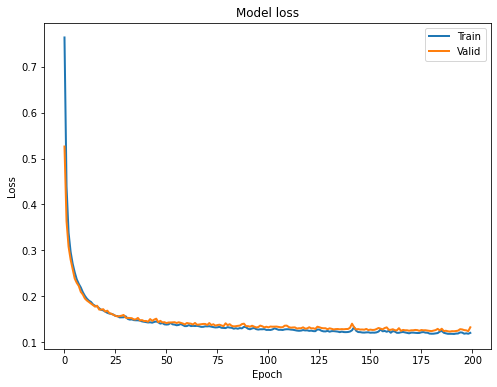

In [23]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Sanity check
Doing a sanity check by validating the reconstruction error on the train data. Here we will reconstruct the entire train data with both 0 and 1 labels.

* Expectation: the reconstruction error of 0 labeled data should be smaller than 1.

* Caution: do not use this result for model evaluation. It may result into overfitting issues.

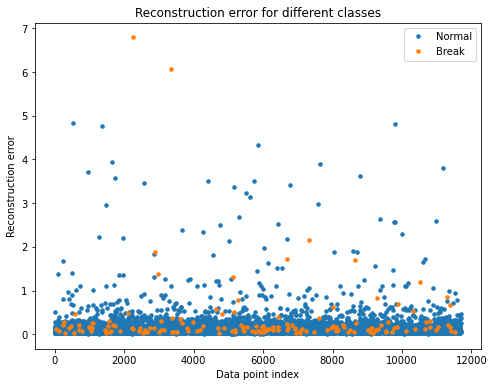

In [24]:
train_x_predictions = lstm_autoencoder.predict(X_train_scaled)
mse = np.mean(np.power(flatten(X_train_scaled) - flatten(train_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_train.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

## Predictions using the Autoencoder
here we show how we can use an Autoencoder reconstruction error for the rare-event classification. We follow this concept: the autoencoder is expected to reconstruct a noif the reconstruction error is high, we will classify it as a sheet-break.
We will need to determine the threshold for this. Also, note that here we will be using the entire validation set containing both y = 0 or 1.


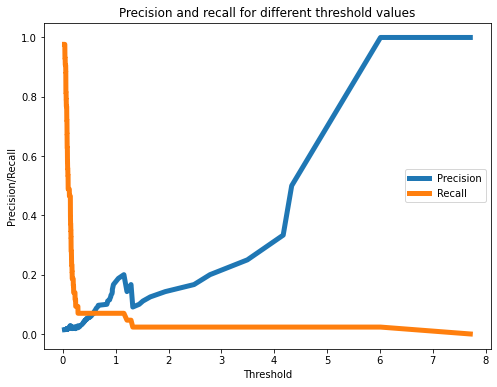

In [25]:
valid_x_predictions = lstm_autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

Now, we will perform classification on the test data.

**We should not estimate the classification threshold from the test data. It will result in overfitting.**

In the following, we show how we can use an Autoencoder reconstruction error for the rare-event classification.
As mentioned before, if the reconstruction error is high, we will classify it as a sheet-break. We will need to determine the threshold for this.
We will use the validation set to identify the threshold.

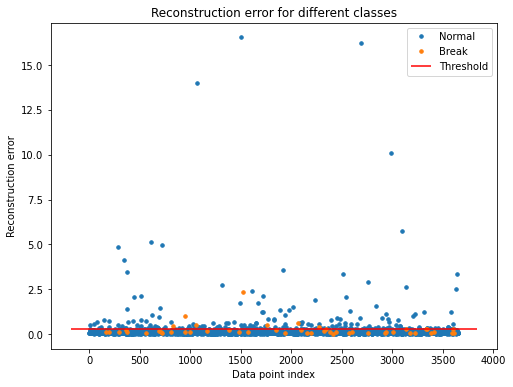

In [26]:
test_x_predictions = lstm_autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = 0.3
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

## Test Accuracy
### Confusion Matrix

In [27]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

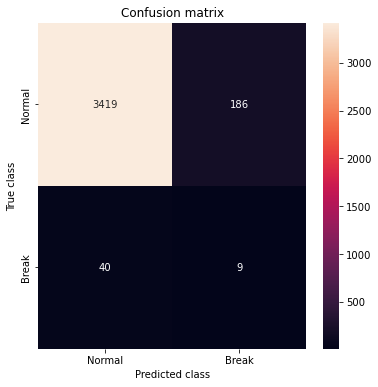

In [28]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### ROC curve and AUC


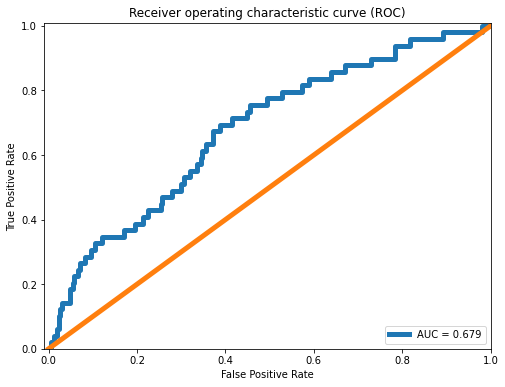

In [29]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

We see approximately 10% improvement in the AUC compared to the dense layer Autoencoder in [1]. From the Confusion Matrix in Figure 5, we could predict 10 out of 39 break instances. 
However, the improvement we achieved in comparison to the dense layer Autoencoder is minor.
The primary reason is LSTM model has more parameters to estimate. It becomes important to use regularization with LSTMs. Regularization and other model improvements will be discussed in the next post.